TypeError: Invalid shape (100,) for image data

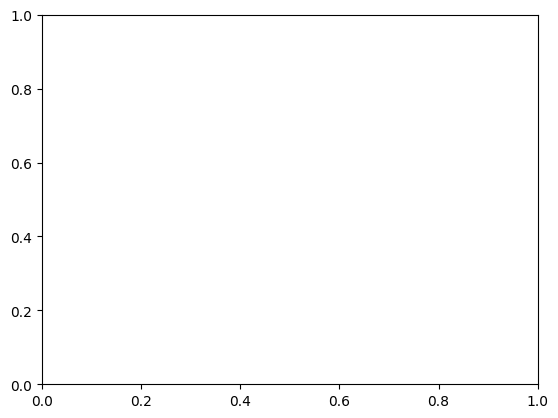

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ---------- 1. 各生理信号のエンコーダ ----------
class ChannelEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        return self.proj(x)

# ---------- 2. マルチモーダル統合用 Transformer ----------
class MultiModalTransformer(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, num_layers=2, num_modalities=3):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, 500, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, 1)
        self.num_modalities = num_modalities

    def forward(self, x_list):
        # x_list: [BVP, GSR, HR] の list、各 (batch, seq_len, embed_dim)
        x = torch.stack(x_list, dim=2)             # (batch, seq_len, modality, embed)
        x = x.mean(dim=2) + self.pos_embed[:, :x.size(1)]  # モダリティ平均＋位置符号
        out = self.transformer(x)
        return self.fc_out(out.mean(dim=1))

# ---------- 3. Attention 可視化用 ----------
def visualize_attention(model, x):
    layer = model.transformer.layers[0]
    attn = layer.self_attn
    attn_out, attn_weights = attn(x, x, x, need_weights=True)
    plt.imshow(attn_weights[0, 0].detach().cpu().numpy(),
               cmap='viridis', aspect='auto')
    plt.xlabel("Key Time Step")
    plt.ylabel("Query Time Step")
    plt.title("Attention Map")
    plt.colorbar()
    plt.show()
    return attn_weights

# ---------- 4. 実行例 ----------
batch, seq_len, feat = 1, 100, 3
BVP = torch.randn(batch, seq_len, feat)
GSR = torch.randn(batch, seq_len, feat)
HRV = torch.randn(batch, seq_len, feat)

enc_bvp = ChannelEncoder(feat, 64)
enc_gsr = ChannelEncoder(feat, 64)
enc_hrv = ChannelEncoder(feat, 64)

model = MultiModalTransformer()
x_list = [enc_bvp(BVP), enc_gsr(GSR), enc_hrv(HRV)]
out = model(x_list)

# Attention 可視化
_ = visualize_attention(model, x_list[0])